In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from matplotlib import image
from pathlib import Path
from tensorflow.keras import models, layers, Model, Input

from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, UpSampling2D, MaxPooling2D, concatenate

from PIL import Image
from numpy import asarray

In [2]:
isic_input_path = './../../../dataset/ISIC2018_Task1-2_Training_Input_x2/*.jpg'
isic_groundTruth_path = './../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2/*.png'

In [3]:
isic_input = sorted(glob.glob(isic_input_path))
isic_groundTruth = sorted(glob.glob(isic_groundTruth_path))

DATASET_SIZE = len(isic_input)
BATCH_SIZE = 64
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 4
# print(len(isic_groundTruth))

In [4]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

# print(train_size, val_size, test_size)

In [5]:
## Splitting up the dataset for training, validation, and testing

full_ds = tf.data.Dataset.from_tensor_slices((isic_input, isic_groundTruth))
full_ds = full_ds.shuffle(DATASET_SIZE, reshuffle_each_iteration=False)

train_ds = full_ds.take(train_size)

# skip the dataset for train
test_ds = full_ds.skip(train_size)

val_ds = full_ds.skip(val_size)
test_ds = full_ds.take(test_size)

In [9]:
def decode_img(image):
    image = tf.image.decode_jpeg(image, channels=3)
    # resize the image 256*256 
    image =  tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    # Standardise values to be in the [0, 1] range.
    image = tf.cast(image, tf.float32) / 255.0
    
    return image
    
def decode_label(label):
    label = tf.image.decode_png(label, channels=1)
    # Resize the image to the desired size.
    label =  tf.image.resize(label, [IMG_WIDTH, IMG_HEIGHT])
    
    label = tf.where(label > 127, 255*tf.ones_like(label), tf.zeros_like(label))
    label = tf.reshape(label, (IMG_WIDTH, IMG_HEIGHT, 1)) / 255
    label = tf.cast(label, tf.float32)
    return label
    
#     one_hot_map = []

#     for clr in [0, 255]:
#         class_map = tf.equal(label, clr)
#         class_map = tf.reduce_all(class_map,axis=-1)
#         one_hot_map.append(class_map)
    
#     one_hot_map = tf.stack(one_hot_map, axis=-1)
#     one_hot_map = tf.cast(one_hot_map, tf.uint8)
#     return one_hot_map

    
def process_data(image, label):
    image = tf.io.read_file(image)
    image = decode_img(image)
    
    label = tf.io.read_file(label)
    label = decode_label(label)
    
    return image, label   

In [10]:
# Use Dataset.map to apply this transformation.
processed_train_ds = train_ds.map(process_data)
processed_val_ds = val_ds.map(process_data)
processed_test_ds = test_ds.map(process_data)

In [11]:
for image, label in train_ds.take(1):
    print('Image shape:', image.numpy())
    print('Label:', label.numpy())
print()

## Getting the output size
output_size = 0
for image, label in processed_train_ds.take(1):
    output_size = label.numpy().shape[2]
    print('Image shape:', image.numpy().shape)
    print('Label:', label.numpy().shape)
plt.figure(figsize=(20, 10))

print(output_size)

print(label)
plt.subplot(1, 4, 1)
plt.imshow(image.numpy())
plt.axis('off')

plt.subplot(1, 4, 2)
# plt.imshow(tf.argmax(label.numpy(), axis=2))
plt.imshow(label.numpy())
plt.axis('off')

In [12]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def display(image, ground_truth, prediction, num):
    plt.figure(figsize=(20, 20))
    colors = ['black', 'green', 'red']
    for i in range(num):
        plt.subplot(4, 3, 3*i+1)
        plt.imshow(image[i])
        title = plt.title('The actual image')
        plt.setp(title, color=colors[0])
        plt.axis('off')
        
        plt.subplot(4, 3, 3*i+2)
        plt.imshow(ground_truth[i])
        title = plt.title('Ground truth image segmentation')
        plt.setp(title, color=colors[1])
        plt.axis('off')
        
        plt.subplot(4, 3, 3*i+3)
        plt.imshow(prediction[i] > 0.5)
        title = plt.title('Prediction image segmentation')
        plt.setp(title, color=colors[2])
        plt.axis('off')

        print("DICE SIMILARITY FOR INPUT {}: {}".format(i, dice_coef(ground_truth[i], prediction[i])))
    plt.show()

    
def show_predictions(processed_test_ds, num=3):
    image_test_batch, label_test_batch = next(iter(processed_test_ds.batch(3)))
    prediction = model.predict(image_test_batch)
    display(image_test_batch, label_test_batch, prediction, num)

    
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(processed_test_ds)

In [13]:
from model import *

model = unet(output_size)

# if (output_size > 2):
#     print("Loss Function: categorical_crossentropy")
#     model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy', dice_coef2])
# else:
#     print("Loss Function: binary_crossentropy")
#     model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy', dice_coef2])

print("Loss Function: dice similarity coefficient")
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=['accuracy', dice_coef])

print()
model.summary()

SIGMOID
Loss Function: dice similarity coefficient

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________

DICE SIMILARITY FOR INPUT 0: 0.47275930643081665
DICE SIMILARITY FOR INPUT 1: 0.9391518235206604
DICE SIMILARITY FOR INPUT 2: 0.938105583190918


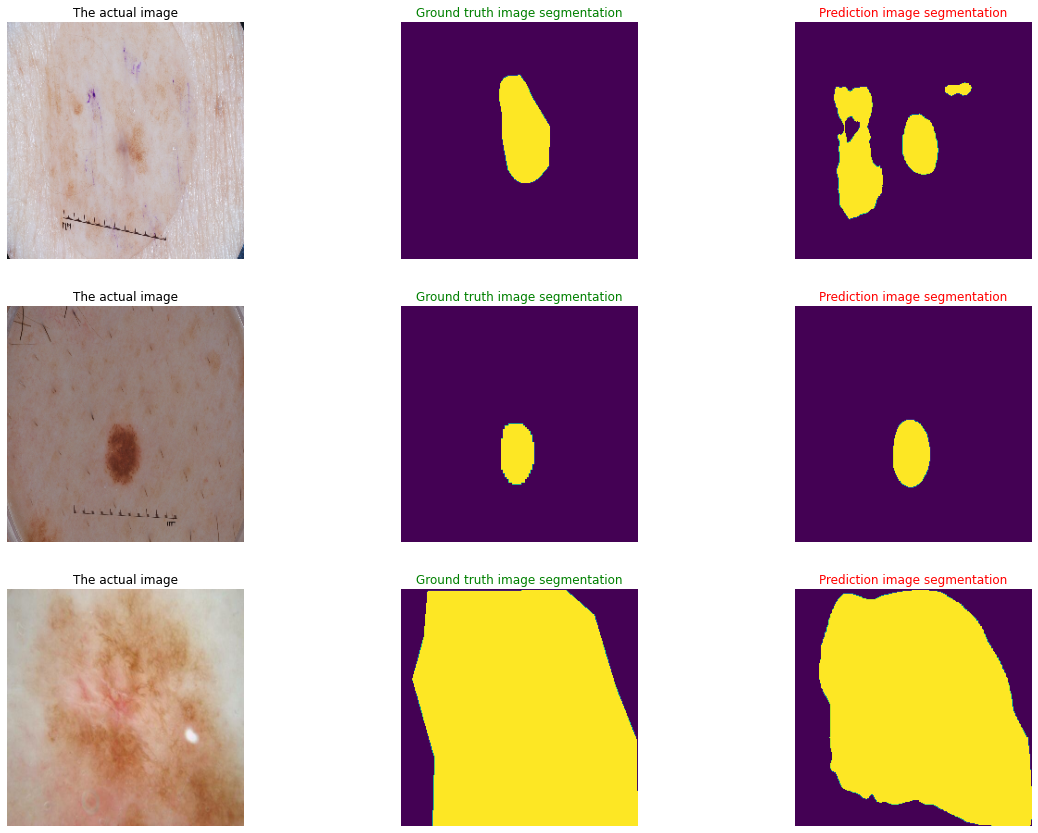

29/29 [==============================] - 162s 6s/step - loss: 0.1079 - accuracy: 0.9411 - dice_coef: 0.8921 - val_loss: 0.1064 - val_accuracy: 0.9415 - val_dice_coef: 0.8936


In [14]:
history = model.fit(processed_train_ds.batch(BATCH_SIZE), 
                    validation_data=processed_val_ds.batch(BATCH_SIZE), 
                    epochs=15, callbacks=[DisplayCallback()])

In [15]:
results = model.evaluate(processed_test_ds.batch(BATCH_SIZE), verbose=1)
print(results)

5/5 [==============================] - 11s 2s/step - loss: 0.0981 - accuracy: 0.9418 - dice_coef: 0.9019
[0.09805030822753906, 0.94175076, 0.9019497]


In [16]:
image_test_batch, label_test_batch = next(iter(processed_test_ds.batch(test_size)))
predictions = model.predict(image_test_batch)

print(predictions.shape)
# plt.imshow(predictions[2])

(259, 256, 256, 1)


In [17]:
bad_dsc = 0
total_dsc = 0
length = predictions.shape[0]
for i in range(length):
    dsc = dice_coef(label_test_batch[i], predictions[i])
    if dsc < 0.7:
        bad_dsc += 1
        print("Index {}, dsc is {}".format(i, dsc))
    total_dsc += dsc

print()
print("There are {} bad dsc".format(bad_dsc))
print("Average dsc: ", total_dsc/length)

Index 0, dsc is 0.4727591574192047
Index 9, dsc is 0.6577203869819641
Index 15, dsc is 0.34432125091552734
Index 20, dsc is 0.546074628829956
Index 24, dsc is 0.6073885560035706
Index 33, dsc is 0.6258256435394287
Index 39, dsc is 0.38220715522766113
Index 52, dsc is 0.6231064796447754
Index 56, dsc is 0.16993245482444763
Index 57, dsc is 0.4141281545162201
Index 65, dsc is 0.6750569343566895
Index 80, dsc is 0.3102189004421234
Index 85, dsc is 0.5088637471199036
Index 87, dsc is 0.36523354053497314
Index 94, dsc is 0.6275017261505127
Index 95, dsc is 0.4599953293800354
Index 100, dsc is 0.3534969091415405
Index 108, dsc is 0.06893010437488556
Index 113, dsc is 0.5452878475189209
Index 122, dsc is 0.3312092423439026
Index 127, dsc is 0.4791422188282013
Index 159, dsc is 0.5084734559059143
Index 163, dsc is 0.48615655303001404
Index 182, dsc is 0.21847134828567505
Index 201, dsc is 0.5903913974761963
Index 208, dsc is 0.6816142797470093
Index 212, dsc is 0.27003079652786255
Index 214, d

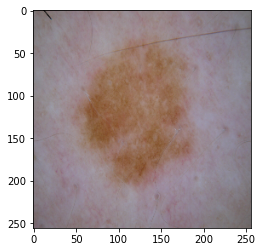

In [18]:
plt.imshow(image_test_batch[5])

In [19]:
################# HERE I USED SIGMOID INSTEAD OF SOFTMAX, INIT KERNEL IS 32